# Efficient Large-Scale Time-Series Search

This notebook demonstrates how to leverage TSPulse's compact embeddings for scalable and efficient time-series search on large datasets, using fast indexing techniques such as [FAISS](https://github.com/facebookresearch/faiss).
For an introduction to time-series search with TSPulse, see [this notebook](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/tspulse_search_simple_example.ipynb).

We compare search performance with and without fast indexing, and show that using FAISS can result in 6-8× faster retrieval, depending on the computation environment.
This notebook is ideal for users interested in deploying time-series search systems in real-world scenarios where speed, scalability, and accuracy are essential.

## Imports

In [1]:
# Uncomment if not installed
# Linux environment recommended to avoid installation issues
# !pip install faiss-cpu

In [2]:
import os
import time

import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import set_seed

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.models.tspulse.utils.helpers import get_embeddings
from tsfm_public.toolkit.dataset import ClassificationDFDataset
from tsfm_public.toolkit.time_series_classification_preprocessor import (
    TimeSeriesClassificationPreprocessor,
)
from tsfm_public.toolkit.util import convert_tsfile_to_dataframe

## Important arguments

In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

CONTEXT_LENGTH = 512

# model
mode = "register"  # parameter for embedding
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"

# search
k = 3

## Data processing

In [4]:
# Uncomment the following lines if the data is not yet downloaded
# !curl -OL http://www.timeseriesclassification.com/aeon-toolkit/Archives/Univariate2018_ts.zip
# !unzip Univariate2018_ts.zip

In [5]:
def get_data(split):
    # Select the top 20 largest datasets
    dataname_list = [
        "ElectricDevices",
        "Crop",
        "FordB",
        "FordA",
        "NonInvasiveFetalECGThorax1",
        "PhalangesOutlinesCorrect",
        "NonInvasiveFetalECGThorax2",
        "MelbournePedestrian",
        "StarLightCurves",
        "Wafer",
        "TwoPatterns",
        "HandOutlines",
        "UWaveGestureLibraryY",
        "UWaveGestureLibraryX",
        "UWaveGestureLibraryZ",
        "UWaveGestureLibraryAll",
        "Strawberry",
        "ProximalPhalanxOutlineCorrect",
        "DistalPhalanxOutlineCorrect",
        "MiddlePhalanxOutlineCorrect",
    ]
    df_base = []
    for dataname in dataname_list:
        data_path = os.path.join(
            "Univariate_ts",
            dataname,
            f"{dataname}_{split}.ts",
        )

        _df = convert_tsfile_to_dataframe(data_path, return_separate_X_and_y=False)
        _df["dataname"] = dataname
        df_base.append(_df)
    df_base = pd.concat(df_base, axis=0).reset_index(drop=True)
    df_base["new_class_vals"] = df_base["dataname"] + "_" + df_base["class_vals"]
    df_base.rename(columns={"class_vals": "old_class_vals"}, inplace=True)
    df_base.rename(columns={"new_class_vals": "class_vals"}, inplace=True)
    return df_base

In [6]:
label_column = "class_vals"
input_columns = ["dim_0"]  # because univariate ts
tsp = TimeSeriesClassificationPreprocessor(
    input_columns=input_columns,
    label_column=label_column,
    scaling=True,
)

# train data
df_train = get_data("TRAIN")
tsp.train(df_train)

df_prep = tsp.preprocess(df_train)
train_dataset = ClassificationDFDataset(
    df_prep,
    id_columns=[],
    timestamp_column=None,
    input_columns=input_columns,
    label_column=label_column,
    context_length=CONTEXT_LENGTH,
    static_categorical_columns=[],
    stride=1,
    enable_padding=False,
    full_series=True,
)

# test data
df_test = get_data("TEST")
df_prep = tsp.preprocess(df_test)
test_dataset = ClassificationDFDataset(
    df_prep,
    id_columns=[],
    timestamp_column=None,
    input_columns=input_columns,
    label_column=label_column,
    context_length=CONTEXT_LENGTH,
    static_categorical_columns=[],
    stride=1,
    enable_padding=False,
    full_series=True,
)
len(train_dataset), len(test_dataset)

(39954, 68194)

## Pre-trained Model Loading

In [7]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=1,
    mask_type="user",
)
model.to(device).eval();

## Embedding Computation

In [8]:
# compute embeddings for train dataset
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
embeddings = []
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
        past_values = batch["past_values"].to(device)
        embs = get_embeddings(model, past_values, mode=mode).cpu()
        embeddings.append(embs.numpy())
train_embeddings = np.concatenate(embeddings).squeeze(axis=1)  # squeeze because of the univariate time-series
print(train_embeddings.shape)

100%|██████████| 313/313 [00:07<00:00, 39.20it/s]

(39954, 240)


## Performance Comparison

In [9]:
def calc_precision_k(cmp, k):
    cmp_k = np.sum(cmp[:, :k], axis=1) / k
    mean_cmp_k = np.mean(cmp_k)
    return mean_cmp_k, cmp_k


def evaluation(index):
    dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    cmp, I_all = [], []
    tic = time.perf_counter()
    torch.cuda.synchronize()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            past_values = batch["past_values"].to(device)
            test_embedding = get_embeddings(model, past_values, mode=mode).squeeze(axis=1).cpu()
            D, I = index.search(test_embedding, k=k)
            I_all.append(I)

            label_test = batch["target_values"].numpy()
            retrieved_label = np.array([[train_dataset[i]["target_values"] for i in _I] for _I in I])
            cmp.append(label_test[:, None] == retrieved_label)
    torch.cuda.synchronize()
    time_search = time.perf_counter() - tic

    I_all = np.concatenate(I_all, axis=0)  # for visualization
    cmp = np.concatenate(cmp, axis=0)
    prec_k, prec_k_each = calc_precision_k(cmp, k)
    return prec_k, prec_k_each, I_all, time_search

In [10]:
# exact search
d = train_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(train_embeddings)
exact_prec_k, _, _, exact_search_time = evaluation(index)


# fast search
d = train_embeddings.shape[1]
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, 100)
index.train(train_embeddings)
index.add(train_embeddings)
index.nprobe = 5
prec_k, prec_k_each, I_all, search_time = evaluation(index)


# comparison
print(f"[Exact search] PREC@{k}={exact_prec_k:.3f}, Elapsed time: {exact_search_time:.3f}")
print(f"[Fast search]  PREC@{k}={prec_k:.3f}, Elapsed time: {search_time:.3f}")
print(f"{exact_search_time / search_time:.1f}x improvement")

100%|██████████| 533/533 [00:49<00:00, 10.70it/s]

[Exact search] PREC@3=0.641, Elapsed time: 631.997
[Fast search]  PREC@3=0.640, Elapsed time: 49.817
12.7x improvement


## Visualization

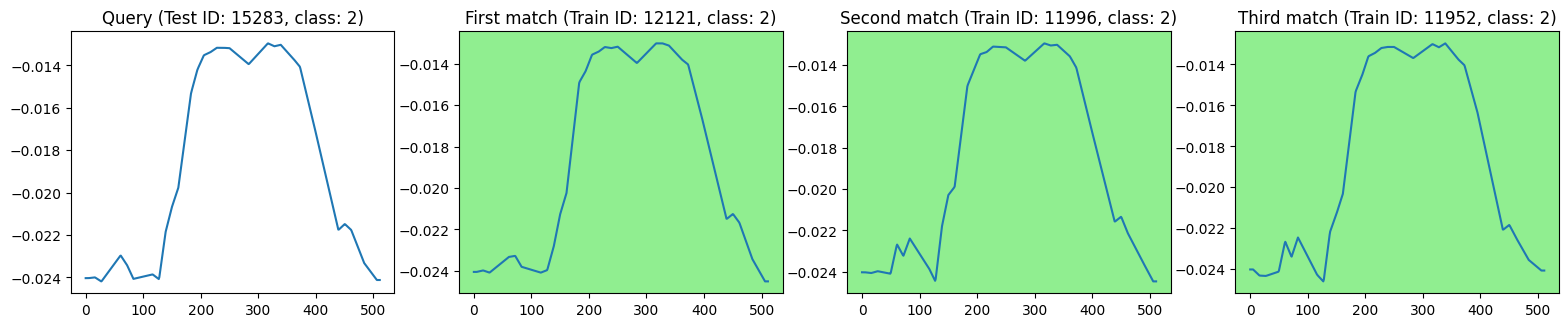

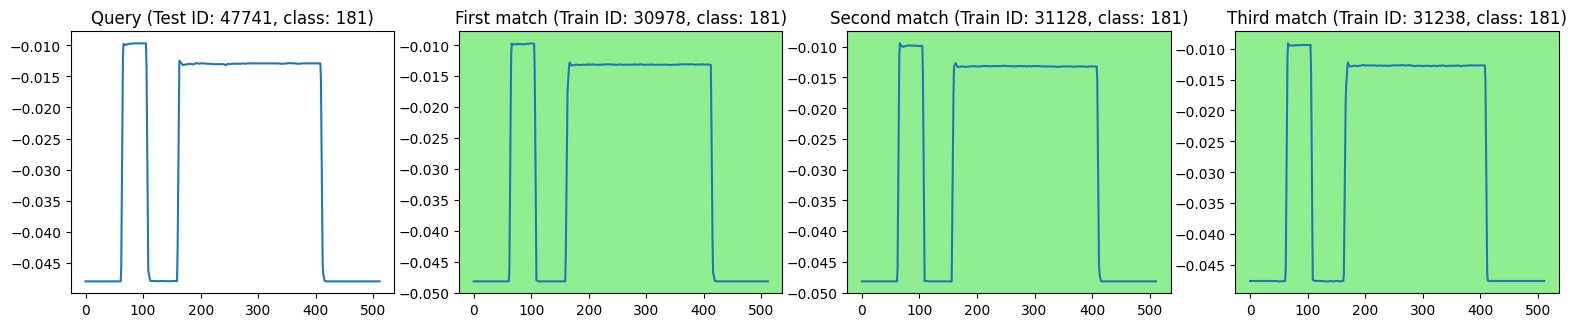

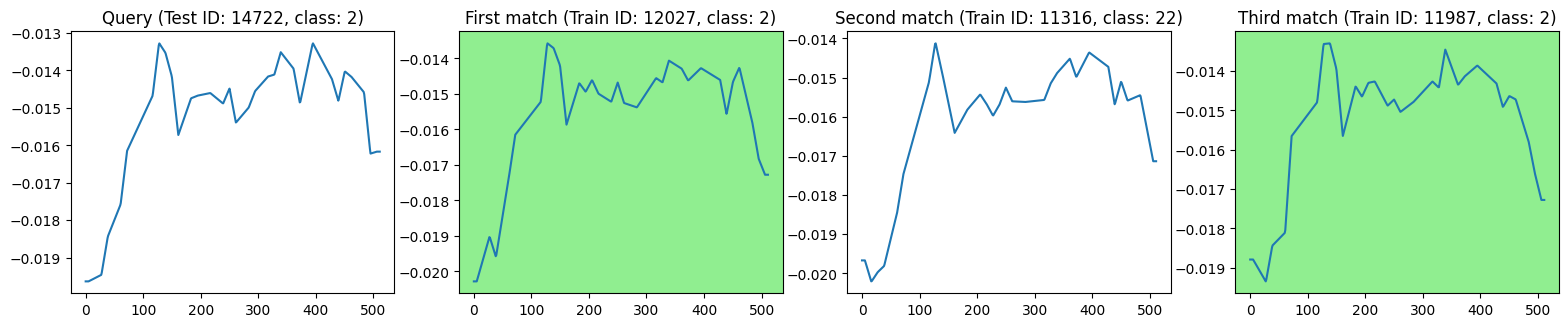

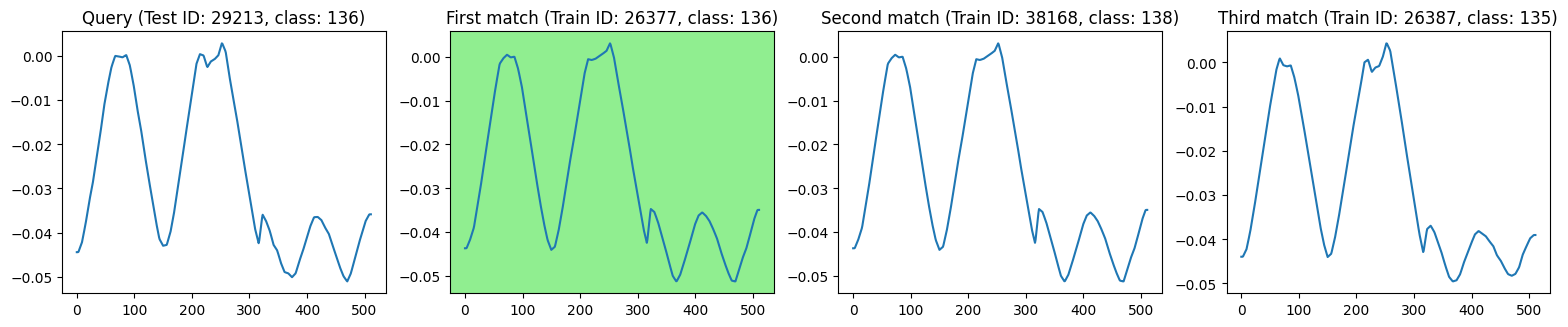

In [11]:
sorted_args = np.argsort(prec_k_each)
visualize_index = [
    sorted_args[int(0.9 * len(sorted_args))],
    sorted_args[int(0.7 * len(sorted_args))],
    sorted_args[int(0.5 * len(sorted_args))],
    sorted_args[int(0.3 * len(sorted_args))],
]

for sample_idx in visualize_index:
    sample = test_dataset[sample_idx]

    first_match = I_all[sample_idx][0]
    second_match = I_all[sample_idx][1]
    third_match = I_all[sample_idx][2]

    label = test_dataset[sample_idx]["target_values"]
    first_label = train_dataset[first_match]["target_values"]
    second_label = train_dataset[second_match]["target_values"]
    third_label = train_dataset[third_match]["target_values"]

    fig, ax = plt.subplots(1, 4, figsize=(6.4 * 3, 3.4))
    ax[0].plot(test_dataset[sample_idx]["past_values"])
    ax[0].set_title(f"Query (Test ID: {sample_idx}, class: {label})")

    ax[1].plot(train_dataset[first_match]["past_values"])
    ax[1].set_title(f"First match (Train ID: {first_match}, class: {first_label})")
    ax[1].set_facecolor("lightgreen") if label == first_label else None

    ax[2].plot(train_dataset[second_match]["past_values"])
    ax[2].set_title(f"Second match (Train ID: {second_match}, class: {second_label})")
    ax[2].set_facecolor("lightgreen") if label == second_label else None

    ax[3].plot(train_dataset[third_match]["past_values"])
    ax[3].set_title(f"Third match (Train ID: {third_match}, class: {third_label})")
    ax[3].set_facecolor("lightgreen") if label == third_label else None